## 包含测距噪声的灵敏度曲线
这个灵敏度曲线用于探测器的优化，主要参考空间中心张佳峰师兄的优化文章，文章链接：https://www.mdpi.com/1424-8220/23/23/9431。
顶层灵敏度曲线只包含三个参数，探测器臂长$L$,加速度噪声$S_a$,测距噪声$S_x$。
这篇文章实际上只包含了测距噪声，如果可以最好加上加速度噪声。
@Copyright: ICTP-ap UCAS Junxi SHI

In [144]:
import numpy as np
import matplotlib.pyplot as plt


In [145]:
pi = np.pi
GM_sun = 1.3271244*1e20 
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
e = 1.6e-19   #库伦

In [146]:
#这里首先给出Robson文章中的灵敏度曲线，随后将把Sx的公式整合在里面
def PSD_tj(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 3.0*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    Sx = 8.0*10**-12
    Sa = 3*10**-15
    Poms = (Sx**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = Sa**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD

### 这里是测距噪声的分解模型
函数Sx就是测距噪声，其依赖于7个参数

同时，一些太极任务中所需要的参数也已经列出

给定Sx所需的参数，便能计算出Sx的数值大小，量级为$10^{-12}$

带入灵敏度曲线的公式，即可与太极Default的灵敏度曲线对比，橙色为优化后的

In [147]:
#这里给定太极的一些固定参数，如果可以增加LISA的更好
eps_het = 0.8   #Heterodyne interference efficiency
R_pd = 0.68     #A/W    Photodiode responsivity
RIN = 1e-8      #Relative intensity laser noise
N_pd = 4.0      #Photo detector phase number
U_pd = 2.0e-9   #V/sqrt(Hz)  Photodetectorvoltagenoise
C_pd = 10.0e-12 #F    Photodiode capacitance
I_pd = 1.5e-12  #A/sqrt(Hz)     Currentnoise
P_tel = 2.0     #W   Laser power transmitted through the telescope
eps_opt = 0.853 #Totalopticalefficiency
L = 3e9         #m
D = 0.4         #cm     Diameter of telescope


In [148]:
from scipy.special import jv
m = 0   #modulation depth

lamb = 1064.0e-9    #激光波长
   
#f_uso = 0   #ultrastable oscillator frequency
def Sx(paras):
    f_low,f_up,f_adc,f_pt,f_uso,m,P_loc = paras     #一共七个优化参数

    

    f_het = f_up    #beat-note frequency
    j0 = jv(0,m)    #贝塞尔函数,下同
    j1 = jv(1,m)
   
    P_rec = 0.4073*pi**2*D**4*P_tel*eps_opt/(8*L**2*lamb**2)     #吸收功率

    #相位噪声
    phi_sn = np.sqrt(2*e*(P_loc+P_rec)/(R_pd*eps_het*P_loc*P_rec))
    phi_rin = RIN*np.sqrt((P_loc**2+P_rec**2)/(2*eps_het*P_loc*P_rec))
    phi_en = (np.sqrt(2*N_pd)/R_pd)*np.sqrt((I_pd**2+(2*pi*C_pd*f_up*U_pd)**2)/(eps_het*P_loc*P_rec))
    phi_tot = np.sqrt(phi_sn**2+phi_rin**2+phi_en**2)

    #carrier noise and sideband noise
    Sx_car = (lamb/2/pi)*(1/j0**2)*phi_tot
    Sx_sb = (1/np.sqrt(2))*(lamb/2/pi)*(f_het/f_uso)*(1/j1**2)*phi_tot
    
    return Sx_car,Sx_sb

para_test = [5.0e6,25.0e6,59.0e6,57.0e6,3.363e9,0.44,2.06e-3]
sx_result = Sx(para_test)[0]+Sx(para_test)[1]
print(f"总 Sa: {sx_result:.3e} meters")


总 Sa: 4.080e-12 meters


### 虽然量级对了，但是数值上仍然存在差别，不知为何hh，这里就简单列四个结果把对应number1，5, 13，14，20
1：3.694e-12;
5：3.727e-12;
13：4.078e-12;
14：3.627e-12;
20：3.760e-12;

### 修改为带有测距噪声参数的灵敏度曲线


In [149]:
#根据robson的灵敏度曲线，修改为带有测距噪声的版本
def PSD_tj_Sx(f,paras_for_Sx):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 3.0*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   

    #这里将默认的参数替换成优化后的参数
    sx = Sx(paras_for_Sx)
    sx = sx[0]+sx[1]
    sa = 3*10**-15
    Poms = (sx**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = sa**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise


    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**alpha + beta * f * np.sin(k * f)) * (1 \
                                        + np.tanh(gamma*(f_k - f)))   # Confusion noise
    
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD

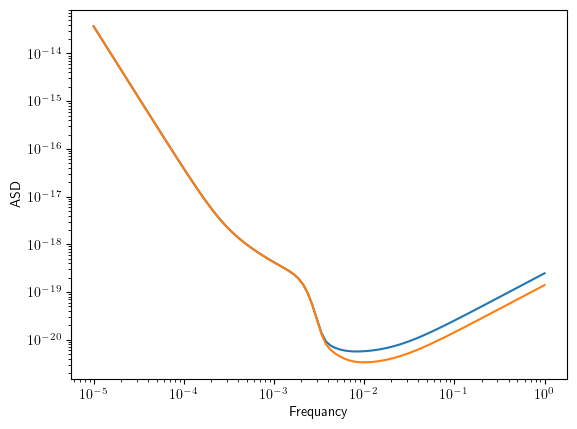

In [150]:
freq = np.logspace(-5,0,100)
plt.plot(freq,np.sqrt(PSD_tj(freq)))
plt.plot(freq,np.sqrt(PSD_tj_Sx(freq,para_test)))
plt.xlabel('Frequancy')
plt.ylabel('ASD')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 下面这个代码列出了所有的约束条件，优化结果需要同时满足以下全部约束条件

In [151]:

def check_constraints(
    delta_x_sideband,  # δx_sideband 来自Sx[1]
    delta_x_total,     # δx^total 来自Sx[0]+Sx[1]
    f_adc,     # 单位 Hz
    f_pt,      # 单位 Hz
    f_low,   # 单位 Hz
    f_up,   # 单位 Hz
    f_uso,     # 单位 Hz
    m
):
    """
    根据所给约束，判断是否全部满足。
    单位约定：
      - 各频率 (f_ADC, f_PT, f_lower, f_upper, f_USO) 使用 Hz
      - δx_sideband, δx_total 使用同样的位移单位
      - m 为无量纲

    返回值:
      True  - 若所有约束均满足
      False - 若有任一约束不满足
    """

    # 1) δx_sideband < (1/10)·δx_total
    if not (delta_x_sideband < 0.1 * delta_x_total):
        return False

    # 2) 判断f_USO能否被f_ADC整除
    if not (f_uso % f_adc == 0):
        return False

    # 3) 判断f_USO能否被f_PT整除
    if not (f_uso % f_pt == 0):
        return False

    # 4) f_ADC > 2 * f_upper
    if not (f_adc > 2 * f_up):
        return False

    # 5) |f_ADC - f_PT| < f_lower
    if not (abs(f_adc - f_pt) < f_low):
        return False

    # 6) f_lower >= 2 MHz  (此处 f_lower 已是 Hz, 因此 2 MHz = 2e6 Hz)
    if not (f_low >= 2e6):
        return False

    # 7) f_upper <= 25 MHz (同理，25 MHz = 25e6 Hz)
    if not (f_up <= 25e6):
        return False

    # 8) f_USO < 5 GHz     (5 GHz = 5e9 Hz)
    if not (f_uso < 5e9):
        return False

    # 9) f_PT < 98 MHz    (98 MHz = 98e6 Hz)
    if not (f_pt < 98e6):
        return False

    # 10) 0.44 < m < 0.61
    if not (0.44 < m < 0.61):
        return False

    # 如果所有判断都通过，则返回 True
    return True


### 另一方面，除了科学目标满足度，还有一些工程上需要尽可能满足的优化目标
同时，这也是对优化算法进行初步检验的部分

要求优化算法对Gam_1和Gam_2的优化能够接近

张佳锋文章中的结果，以保证算法的正常工作

景祺先用Gam_1和Gam_2进行优化算法的尝试，目前一些用于比较的数值已列出

In [ ]:
#这里用Gamma加下标表示每个工程优化目标
def Func():
    return 0
def Gam_1(f_low,f_up):
    '''
    频率的差值需要尽可能大
    因此Gam_1的要求是: Max(Gam_1)
    '''
    f_diff = f_up - f_low
    return f_diff

def Gam_2(para_for_Sx):
    '''
    这里是总测距噪声
    自然,测距噪声当然是越小越好
    所以Gam_2的要求是: Min(Gam_2)
    '''
    delta_x = Sx(para_for_Sx)
    delta_x_tot = delta_x[0]+delta_x[1]
    return delta_x_tot

def Gam_3(para_for_Sa):
    '''
    这里是总加速度噪声，自然,加速度噪声当然是越小越好
    臂长的增加能够加强探测器的探测能力，但是会对加速度噪声有更高的要求
    这里需要构建一个手给的加速度噪声与臂长的关系
    同样Gam_3的要求是: Min(Gam_3)
    '''
    delta_a = Func(L)*3.0e-15
    return delta_a


### 类似的，呈现一些科学目标满足度相关联的优化目标,伪代码


In [153]:
#用SciOB表示每个科学优化目标
def SciOB_1(paras):
    '''
    信噪比是判断数据强度的最直接特征，越大越好
    所以要求: Max(SciOB_1)
    '''
    weighting_SNR = Func(paras)
    return weighting_SNR

def SciOB_2(paras):
    '''
    探测范围正相关与探测数量，事件数当然越多越好
    所以要求: Max(SciOB_2)
    '''
    Detec_range = Func(paras)
    return Detec_range

def SciOB_3(paras):
    '''
    Fisher矩阵是最简单和直接的参数估计精度指标
    能够给出参数估计的方差，方差越小越好
    所以要求: Min(SciOB_3)
    '''
    weighting_FIM = Func(paras)
    return weighting_FIM